# Version with 250 Hz input (clean version)

A quick notebook (based on the Quick-Start) where we use a 250Hz input instead of a 20Hz one for classifying IPDs in the usual range of [-90deg, 90deg]. The motivation is that the ITDs associated with this range of IPDs can be approximated as belonging to the range of [-1ms, 1ms] for an input of 20 Hz (see this webpage [here](https://voltage-disturbance.com/power-quality/calculating-phase-difference-between-two-waves/), which is sort of similar to approximations of the human physiological range that are close to / less than 1ms.

### We mainly modify the following hyperparameters:
- `DT: 1 * MS => .1 * MS`
- `TAU: 5 * MS for both hidden and output units => TAU_HIDDEN and TAU_OUTPUT (different values tested)`
- `stimulus_frequency: 20 * HZ => 250 * HZ`

### Other changes used here include:
- 5 hidden units
- different values of lr tested
- updated early stopping implementation

### Main takeaways:
- best performance obtained for membrane time constants < 1 ms.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import torch
import torch.nn as nn

from tqdm.auto import tqdm as pbar
import time

dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('⚠️ DEVICE USED:', device)

⚠️ DEVICE USED: cpu


## Hyperparameters

In [3]:
# Constants
SECONDS = 1
MS = 1e-3
HZ = 1
PI = np.pi

DT = .1 * MS                                      # or large time step to make simulations run faster: 1 * MS
ANF_PER_EAR = 100                                 # repeats of each ear with independent noise

DURATION = .1 * SECONDS                           # stimulus duration (100 ms)
DURATION_STEPS = int(np.round(DURATION / DT))
INPUT_SIZE = 2 * ANF_PER_EAR
NULL_PHASE_DELAYS = False                         # using the usual range (0-pi/2 for each side)
ENVELOPE_POWER = 2                                # higher values make sharper envelopes, easier
RATE_MAX = 600 * HZ                               # maximum Poisson firing rate
STIMULUS_FREQUENCY = 250 * HZ                     # or e.g., 20 * HZ

# Training 
LR = 0.01
N_EPOCHS = 50
EARLY_STOPPING_ENABLED = True
batch_size = 64
n_training_batches = 64
n_testing_batches = 64                            # increase this if you can: e.g. 300, 1000
num_samples = batch_size*n_training_batches

# classes at 15 degree increments
NUM_CLASSES = 180 // 15
print(f'⚠️ Number of classes = {NUM_CLASSES}')

# Network
NUM_HIDDEN = 5                                    # number of hidden units
IE_RATIO = 0.5                                    # ratio of inhibitory:excitatory units (used if DALES_LAW = True). 0 = all excitatory, 1 = all inhibitory 
DALES_LAW = False                                 # When True, units will be only excitatory or inhibitory. When False, units will use both (like a normal ANN) 
if DALES_LAW:
    print('⚠️ Using Dales Law')
else:
    print('⚠️ Without Dales Law')

⚠️ Number of classes = 12
⚠️ Without Dales Law


## Functions

### Stimulus

In [4]:
def input_signal(ipd):
    """
    Generate an input signal (spike array) from array of true IPDs
    """
    num_samples = len(ipd)
    times = np.arange(DURATION_STEPS) * DT # array of times
    phi = 2*np.pi*(STIMULUS_FREQUENCY * times + np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    if NULL_PHASE_DELAYS:
        phase_delays = np.linspace(0, 0, ANF_PER_EAR) # CONTROL CASE (Null phase delays in baseline SNN)
    else:
        phase_delays = np.linspace(0, np.pi/2, ANF_PER_EAR)
    
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)<RATE_MAX*DT*(0.5*(1+np.sin(theta)))**ENVELOPE_POWER
    return spikes

def random_ipd_input_signal(num_samples, tensor=True):
    """
    Generate the training data
    Returns true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    #ipd = np.random.uniform(-7.2*PI/180, 7.2*PI/180, num_samples)  # uniformly random in (-7.2*PI/180, 7.2*PI/180)
    spikes = spikes_from_fixed_idp_input_signal(ipd, tensor)

    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        

    return ipd, spikes

def spikes_from_fixed_idp_input_signal(ipd, tensor=True):
    spikes = input_signal(ipd)
    if tensor:
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return spikes

def show_examples(shown=8):
    ipd = np.linspace(-np.pi/2, np.pi/2, shown)
    #ipd = np.linspace(-7.2*PI/180, 7.2*PI/180, shown)
    
    spikes = spikes_from_fixed_idp_input_signal(ipd, shown).cpu()

    plt.figure(figsize=(10, 4), dpi=100)
    plt.suptitle(f"stimulus_frequency = {STIMULUS_FREQUENCY} Hz", fontsize=12)  # Add TAU to the main title
    
    for i in range(shown):
        plt.subplot(2, shown // 2, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
    plt.tight_layout()

def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local
        
def discretise(ipds):
    return ((ipds+np.pi/2) * NUM_CLASSES / np.pi).long() # assumes input is tensor
    #return ((ipds+7.2*np.pi/180) * NUM_CLASSES / (7.2*2*np.pi/180)).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5) / NUM_CLASSES * np.pi - np.pi / 2
    #return (ipd_indices+0.5) / NUM_CLASSES * (7.2*2*np.pi/180) - 7.2*np.pi/180


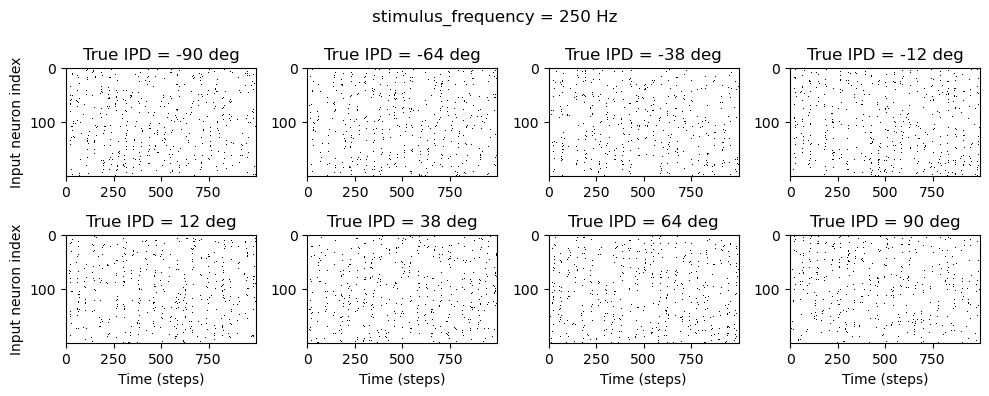

In [5]:
show_examples()

### SNN 

In [6]:
def sigmoid(x, beta):
    return 1 / (1 + torch.exp(-beta*x))

def sigmoid_deriv(x, beta):
    s = sigmoid(x, beta)
    return beta * s * (1 - s)

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        ctx.save_for_backward(inp)
        out = torch.zeros_like(inp)
        out[inp > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        inp, = ctx.saved_tensors
        sigmoid_derivative = sigmoid_deriv(inp, beta=5)
        grad = grad_output*sigmoid_derivative
        return grad

spike_fn  = SurrGradSpike.apply

def membrane_only(input_spikes, weights, tau):
    """
    :param input_spikes: has shape (batch_size, duration_steps, input_size)
    :param weights: has shape  (input_size, num_classes
    :param tau: 
    :return: 
    """
    batch_size = input_spikes.shape[0]
    assert len(input_spikes.shape) == 3
    
    v = torch.zeros((batch_size, NUM_CLASSES), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (input_spikes, weights))
    alpha = np.exp(-DT / tau)
    for t in range(DURATION_STEPS - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

def layer1(input_spikes, w1, tau, sign1, epoch):
    
    if DALES_LAW:
        w1 = get_signed_weights(w1, sign1)

    batch_size = input_spikes.shape[0]

    # First layer: input to hidden
    v = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, w1))
    
    #if epoch == 0 or epoch == N_EPOCHS - 1:  # look into h at first and last epoch, compare to sham convolution SNN
        #print('h at epoch {}: '.format(epoch), h)
    
    alpha = np.exp(-DT / tau)
    
    for t in range(DURATION_STEPS - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    return s_rec

def layer2(s_rec, w2, tau, sign2):
    """Second layer: hidden to output"""
    if DALES_LAW:
        w2 = get_signed_weights(w2, sign2)

    v_rec = membrane_only(s_rec, w2, tau=tau)
    return v_rec

def snn(input_spikes, w1, w2, signs, tau_hidden, tau_output, epoch=0):
    """Run the simulation"""
        
    s_rec = layer1(input_spikes, w1, tau_hidden, signs[0], epoch)
    v_rec = layer2(s_rec, w2, tau_output, signs[1])

    # Return recorded membrane potential of output
    return v_rec

### Dale's Law

In [7]:
def get_dales_mask(nb_inputs, nb_out, ie_ratio) : 

    d_mask = torch.ones(nb_inputs, nb_out)
    #inhib_units = np.random.choice(nb_inputs, int(nb_inputs*ie_ratio), replace=False)
    inhib_units = torch.arange(ie_ratio*nb_inputs, dtype=int)
    d_mask[inhib_units, :] = -1
    return d_mask

def init_weight_matrices(ie_ratio = 0.1):
    """Weights and uniform weight initialisation"""

    # Input to hidden layer
    w1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w1, -bound, bound)

    # Hidden layer to output
    w2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w2, -bound, bound)

    #Get fixed signs for the weight, 90% excitatory 
    signs = [get_dales_mask(*w.shape, ie_ratio).to(w.device) for w in (w1, w2)]

    return w1, w2, signs

def get_signed_weights(w, sign):
    """Get the signed value of the weight"""
    # Note abs is in principle not differentiable.
    # In practice, pytorch will set the derivative to 0 when the values are 0.
    # (see https://discuss.pytorch.org/t/how-does-autograd-deal-with-non-differentiable-opponents-such-as-abs-and-max/34538)
    # This has the adverse effect that, during training, if a synapse reaches 0,
    # it is "culled" and can not be recovered.
    # It should be possible to cheat here and either "wiggle" 0-valued synapses,
    # or to override abs gradient to return a very small random number.

    #TODO try ReLu or other activation
    #TODO reproduce paper https://www.biorxiv.org/content/10.1101/2020.11.02.364968v2.full

   # return torch.max(w, 0)*sign
    return torch.abs(w)*sign

### Training

In [8]:
def train(w1, w2, signs, ipds, spikes, ipds_validation, spikes_validation, tau_hidden, tau_output, lr=0.01, n_epochs=30):
    """
    :param lr: learning rate
    :return:
    """
    # Optimiser and loss function
    optimizer = torch.optim.Adam([w1, w2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    val_loss_hist = []

    val_loss_best_loss = 1e10
    
    print(' ')
    print('TRAINING PROGRESS: ')
    for e in pbar(range(n_epochs)):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, w1, w2, signs, tau_hidden, tau_output, epoch=e)
            # Compute cross entropy loss
            #m = torch.sum(output, 1)*0.01  # Sum time dimension
            m = torch.mean(output, 1)

            reg = 0
            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        
        if EARLY_STOPPING_ENABLED:
            val_local_loss = []
            for x_local, y_local in data_generator(discretise(ipds_validation), spikes_validation):
                # Run network
                output = snn(x_local, w1, w2, signs, tau_hidden, tau_output)
                # Compute cross entropy loss
                #m = torch.sum(output, 1)*0.01  # Sum time dimension
                m = torch.mean(output, 1)

                val_loss = loss_fn(log_softmax_fn(m), y_local) 
                val_local_loss.append(val_loss.item())

            val_loss_hist.append(np.mean(val_local_loss))

            # Early Stopping
            #if torch.tensor(val_loss_hist[-10:]).argmin() == 0  and e>10: 
            if torch.mean(torch.tensor(val_loss_hist[-10:])) >= 70  and e>10: 
                print('Early Stop at Epoch {}!'.format(e+1))
                if DALES_LAW:
                    best_weights = get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs
                else:
                    best_weights = w1, w2, signs

                return best_weights
            

    # Plot the loss function over time
    plt.plot(loss_hist, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

    plt.plot(val_loss_hist, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    #plt.tight_layout()
    plt.show()
    
    if DALES_LAW:
        return get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs
    else:
        return w1, w2, signs

### Testing

In [9]:
def test_accuracy(ipds, spikes, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        #m = torch.sum(output, 1)  # Sum time dimension
        m = torch.mean(output, 1)
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):

    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.suptitle(f"TAU_HIDDEN = {tau_hidden}; TAU_OUTPUT = {tau_output}", fontsize=11)
    
    plt.subplot(121)
    plt.hist(ipd_true * 180 / np.pi, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / np.pi, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    #plt.yticks([])
    plt.ylabel("Count")
    plt.legend(loc='best')
    plt.title('{} True-Estimated Class Distributions'.format(label))
    
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('{} Confusion matrix'.format(label))
    
    #plt.tight_layout()
    plt.show()

def analyse_accuracy(ipds, spikes, run, label):
    ipd_true, ipd_est, confusion, accs = test_accuracy(ipds, spikes, run)
    report_accuracy(ipd_true, ipd_est, confusion, accs, label)
    return 100*np.mean(accs)

## Train Network (250Hz input with +/- 90deg IPDs)

>>> Training No. 1/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.2 ms, TAU_OUTPUT = 5 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

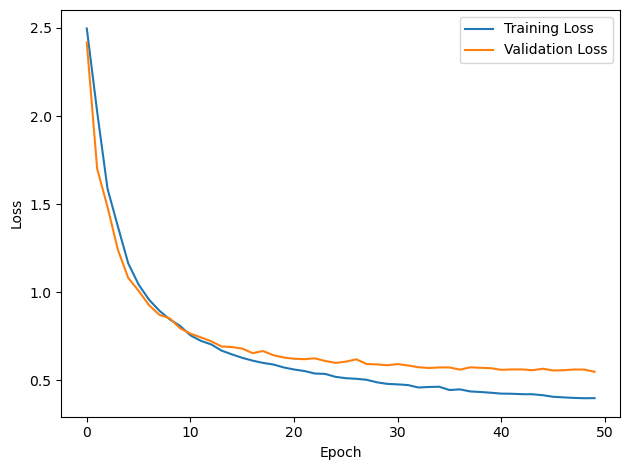

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 88.3%
TRAIN absolute error: 4.4 deg


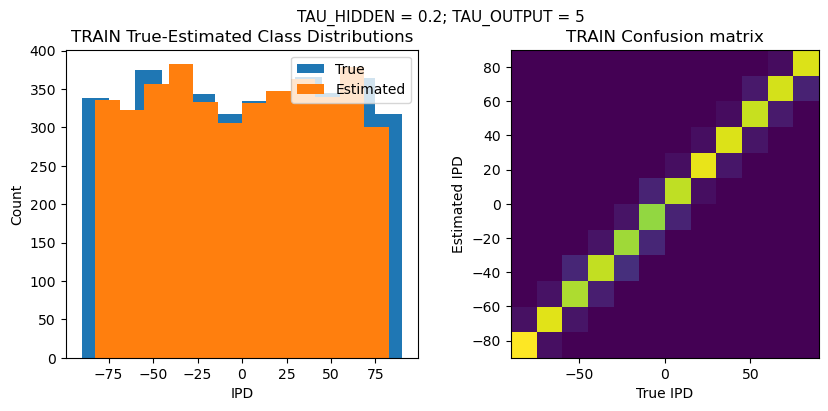


TEST classifier accuracy: 77.3%
TEST absolute error: 5.1 deg


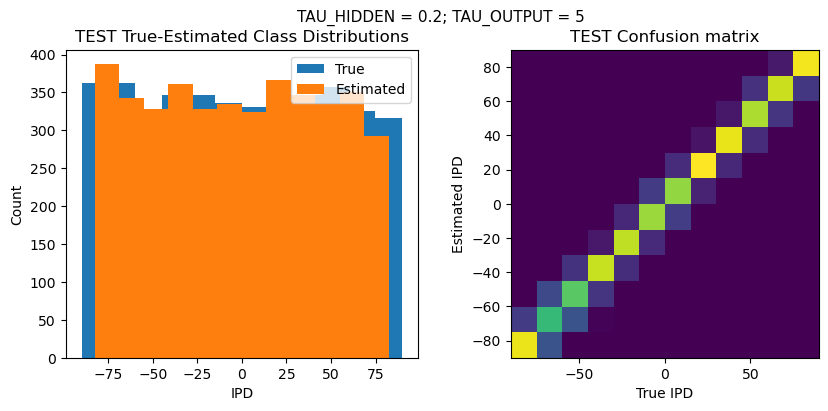

Time taken for this configuration: 48.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 2/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.2 ms, TAU_OUTPUT = 10 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

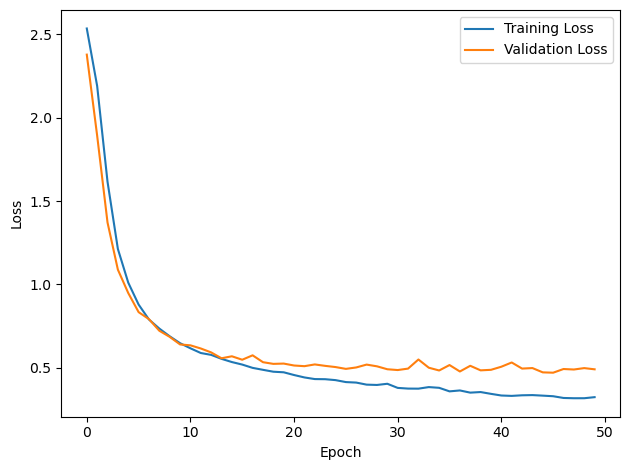

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 88.0%
TRAIN absolute error: 4.3 deg


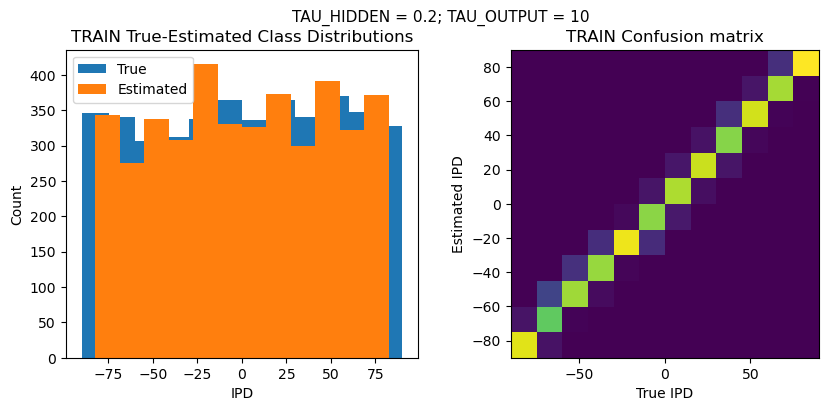


TEST classifier accuracy: 78.0%
TEST absolute error: 4.9 deg


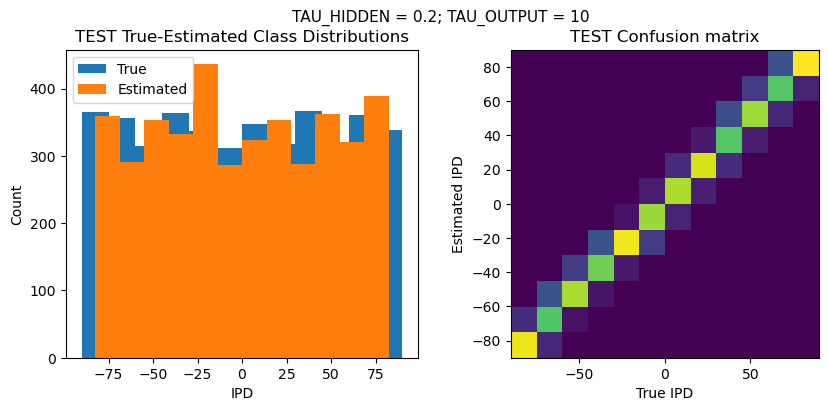

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 3/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.2 ms, TAU_OUTPUT = 20 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

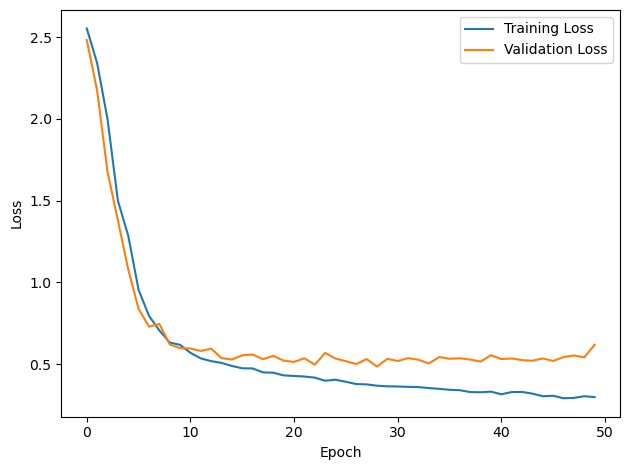

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 86.4%
TRAIN absolute error: 4.5 deg


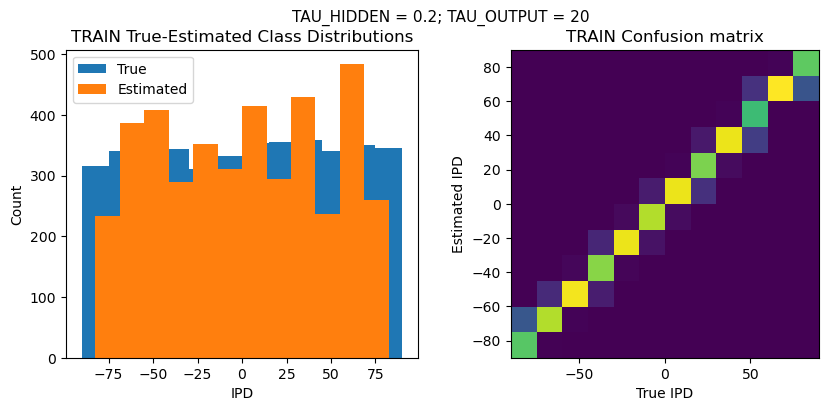


TEST classifier accuracy: 75.3%
TEST absolute error: 5.3 deg


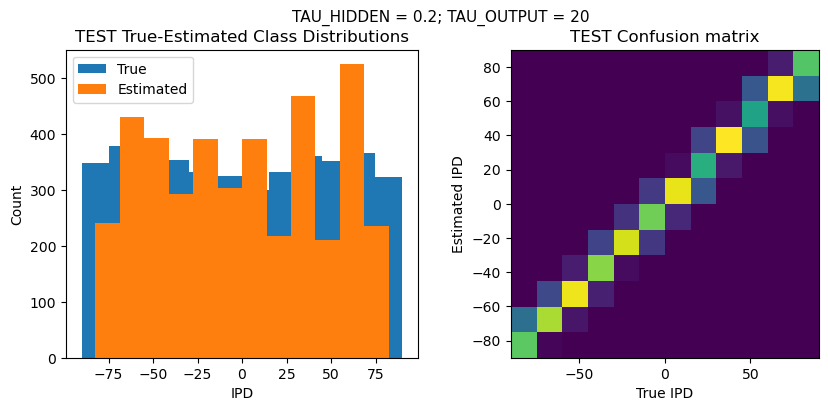

Time taken for this configuration: 52.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 4/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.2 ms, TAU_OUTPUT = 30 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

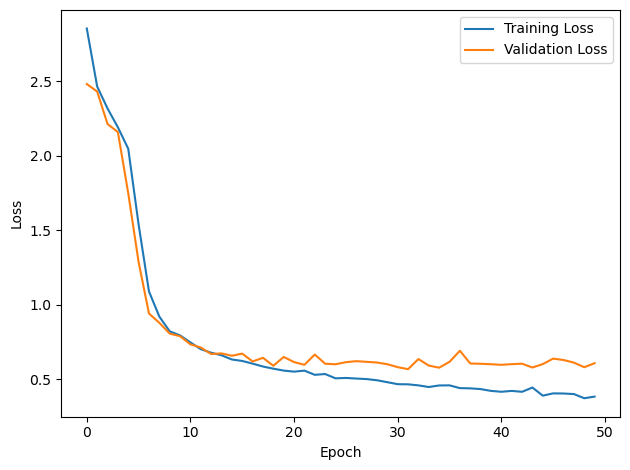

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 85.6%
TRAIN absolute error: 4.7 deg


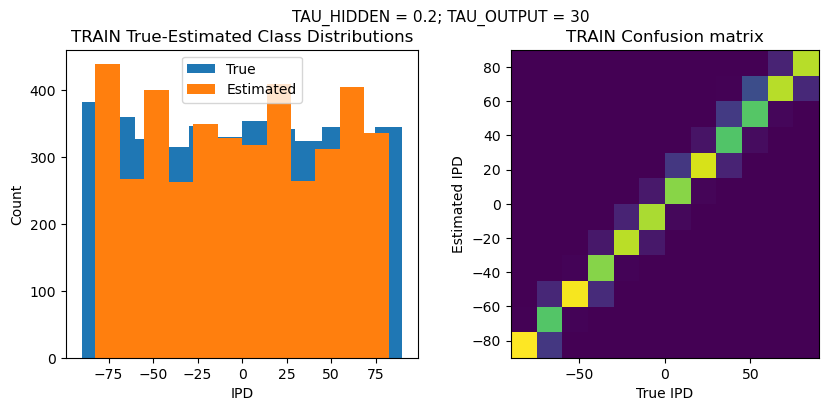


TEST classifier accuracy: 71.1%
TEST absolute error: 5.8 deg


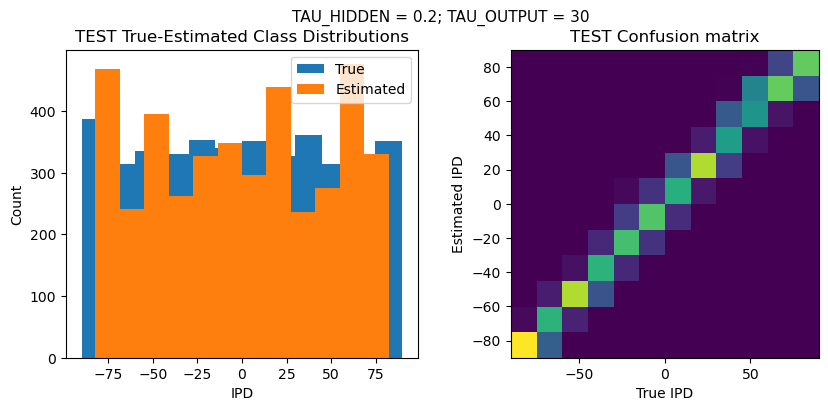

Time taken for this configuration: 90.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 5/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.2 ms, TAU_OUTPUT = 40 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

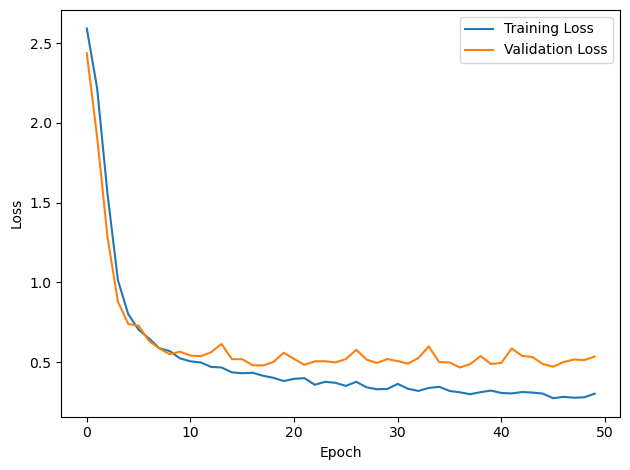

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 86.7%
TRAIN absolute error: 4.5 deg


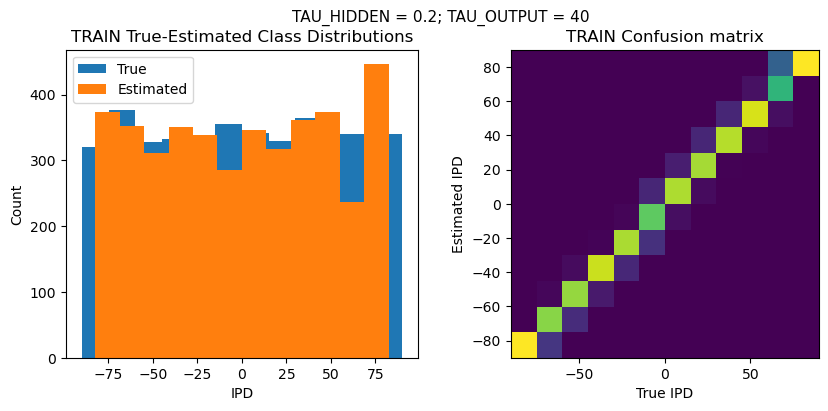


TEST classifier accuracy: 76.2%
TEST absolute error: 5.2 deg


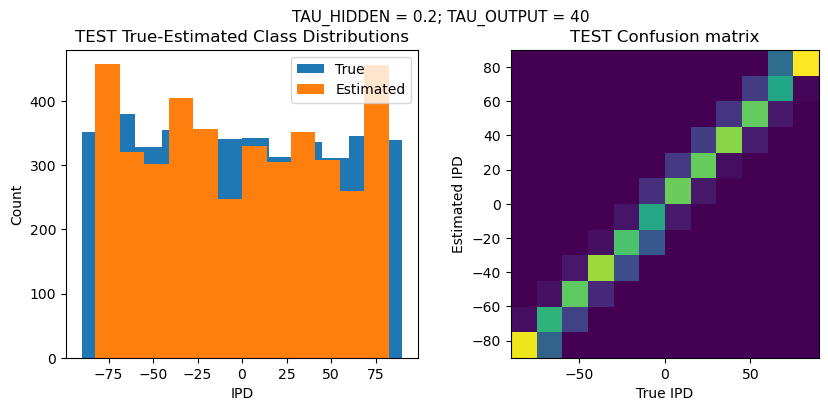

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 6/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.2 ms, TAU_OUTPUT = 50 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

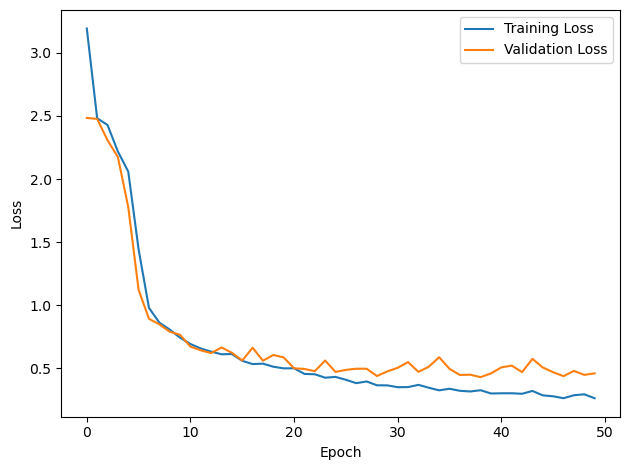

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 90.5%
TRAIN absolute error: 4.2 deg


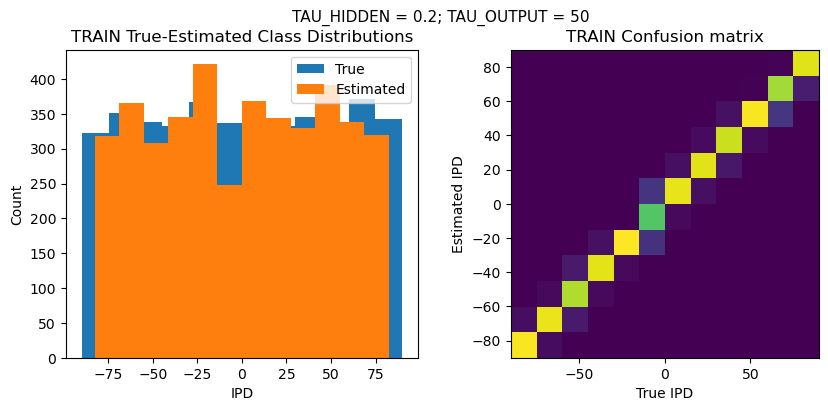


TEST classifier accuracy: 79.7%
TEST absolute error: 4.8 deg


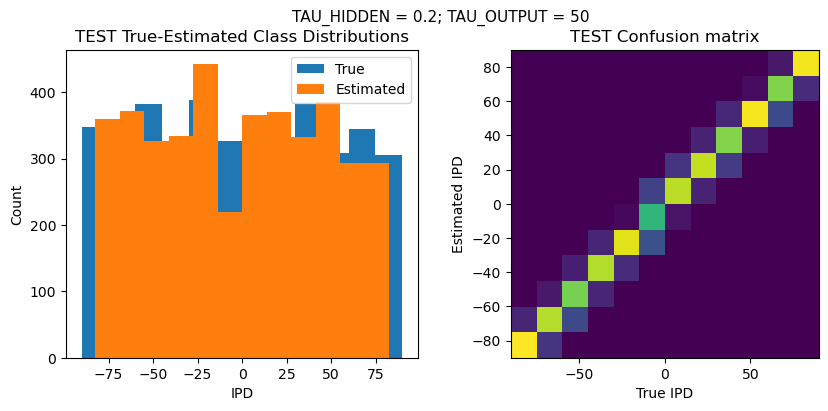

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 7/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.5 ms, TAU_OUTPUT = 5 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

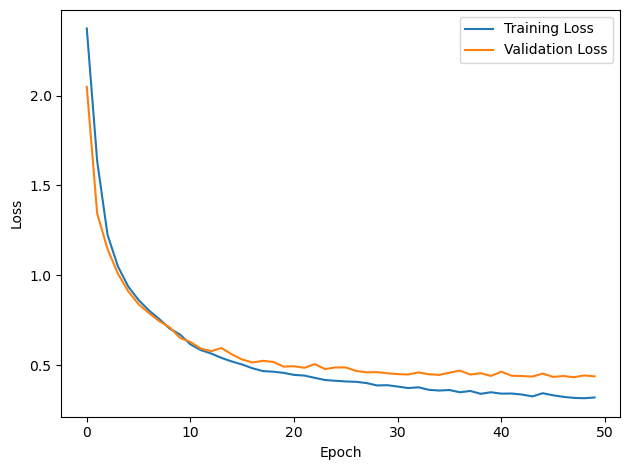

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 88.5%
TRAIN absolute error: 4.3 deg


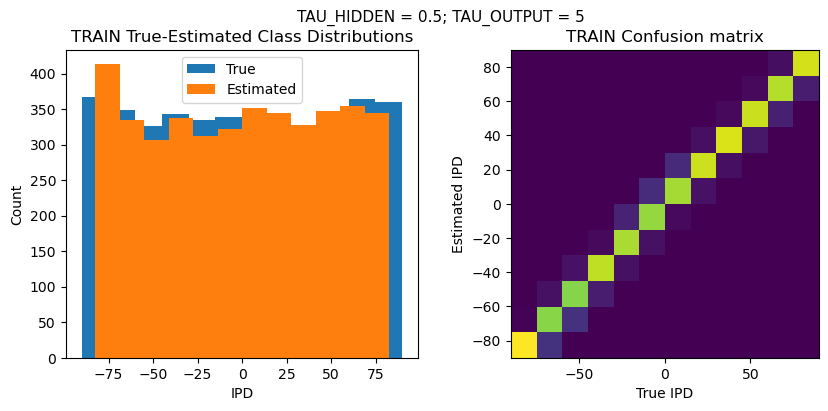


TEST classifier accuracy: 79.9%
TEST absolute error: 4.7 deg


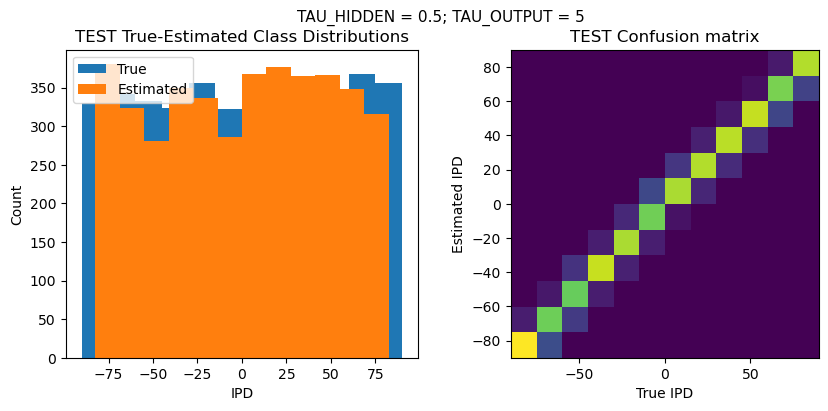

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 8/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.5 ms, TAU_OUTPUT = 10 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

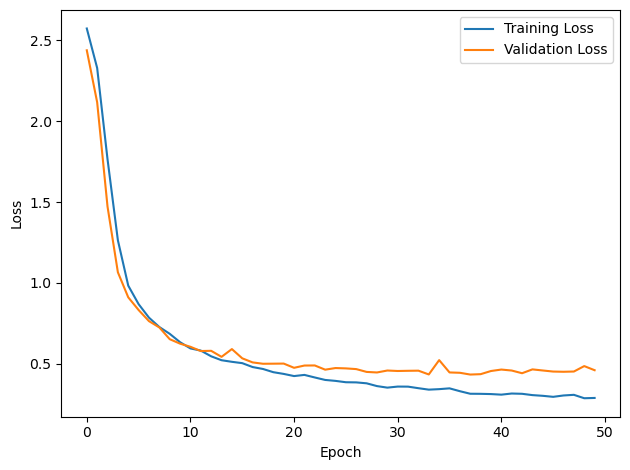

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 90.0%
TRAIN absolute error: 4.2 deg


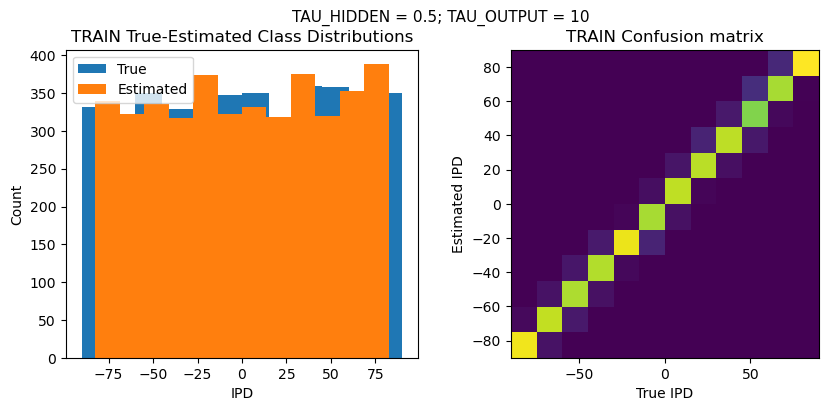


TEST classifier accuracy: 80.5%
TEST absolute error: 4.7 deg


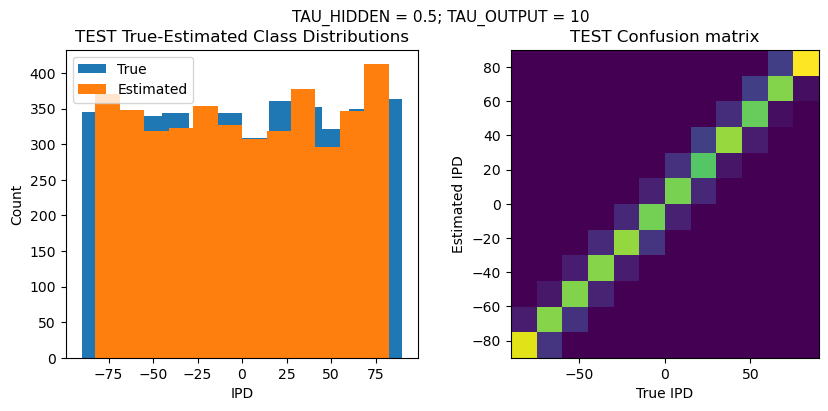

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 9/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.5 ms, TAU_OUTPUT = 20 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

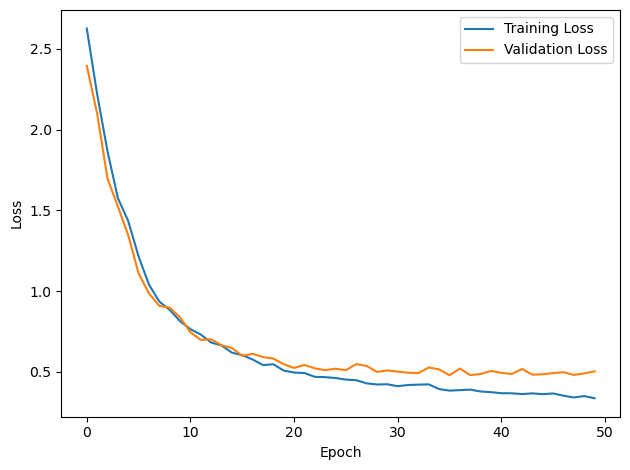

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 86.8%
TRAIN absolute error: 4.5 deg


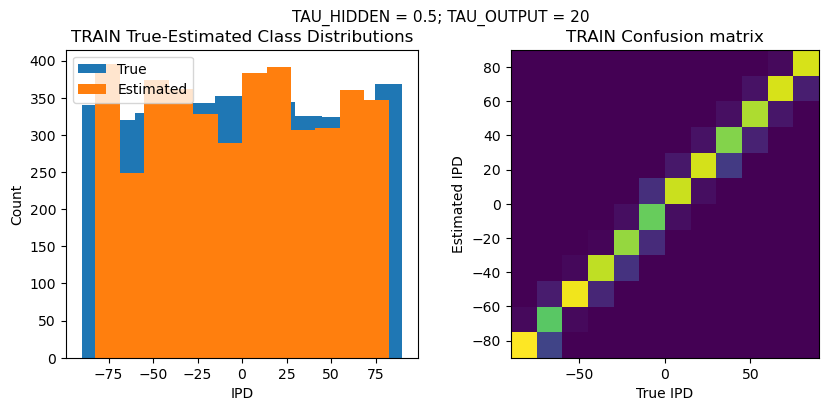


TEST classifier accuracy: 78.1%
TEST absolute error: 5.0 deg


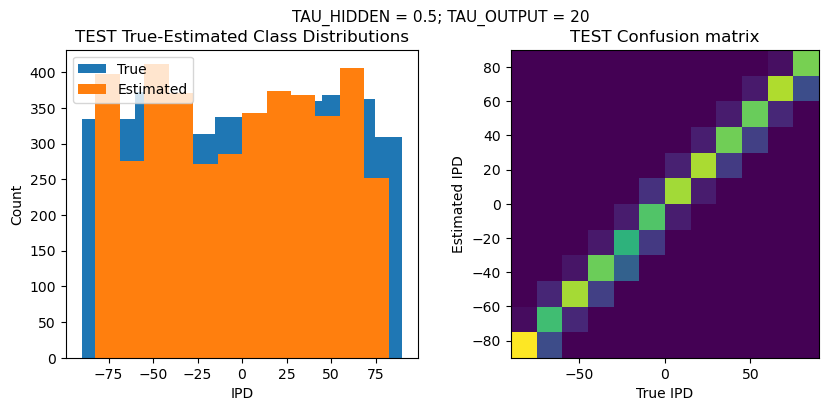

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 10/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.5 ms, TAU_OUTPUT = 30 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

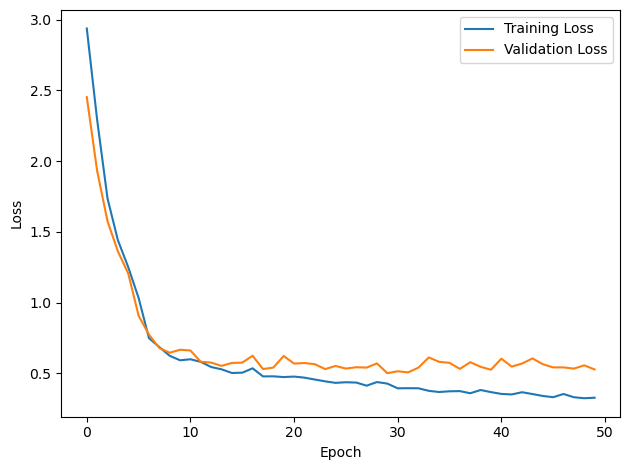

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 89.1%
TRAIN absolute error: 4.3 deg


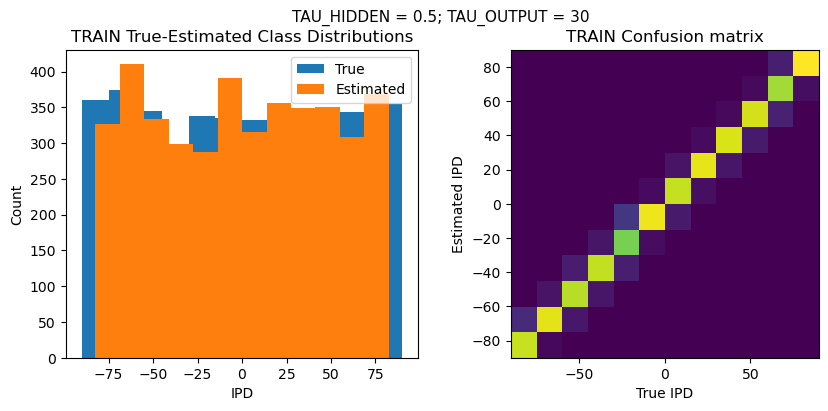


TEST classifier accuracy: 77.9%
TEST absolute error: 5.0 deg


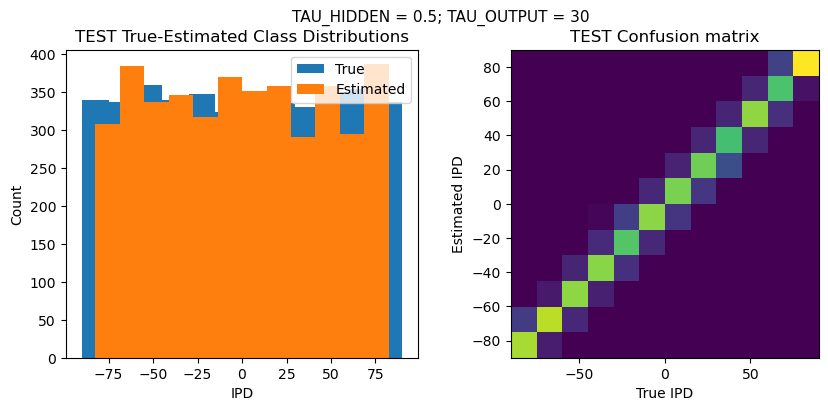

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 11/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.5 ms, TAU_OUTPUT = 40 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

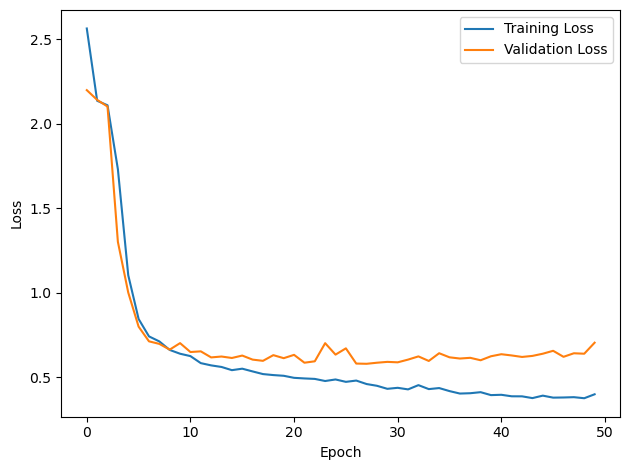

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 82.6%
TRAIN absolute error: 5.0 deg


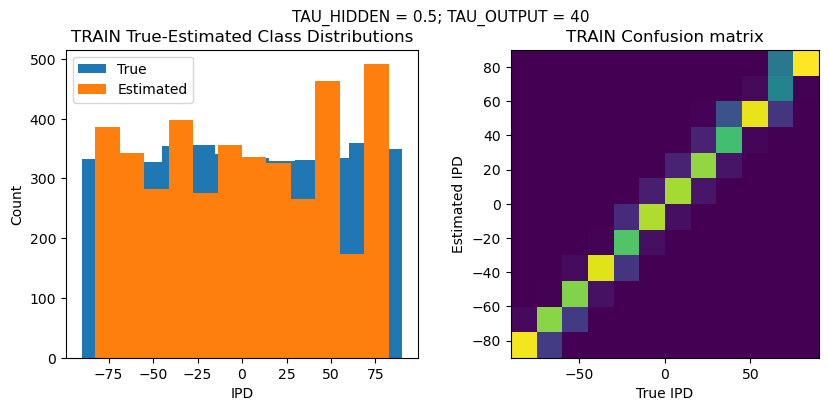


TEST classifier accuracy: 68.4%
TEST absolute error: 6.0 deg


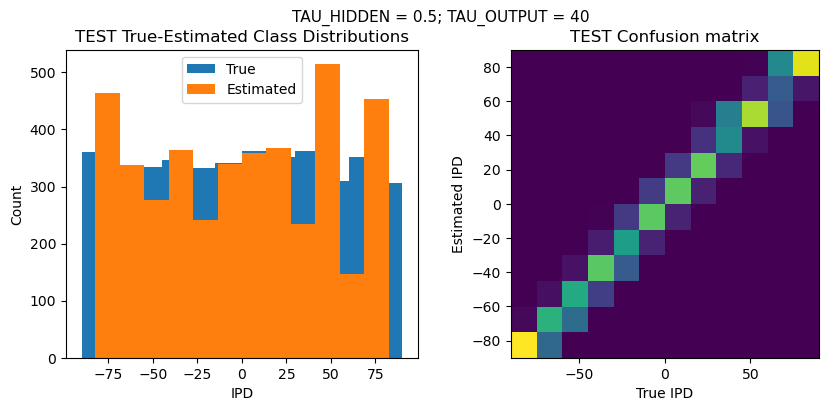

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 12/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 0.5 ms, TAU_OUTPUT = 50 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

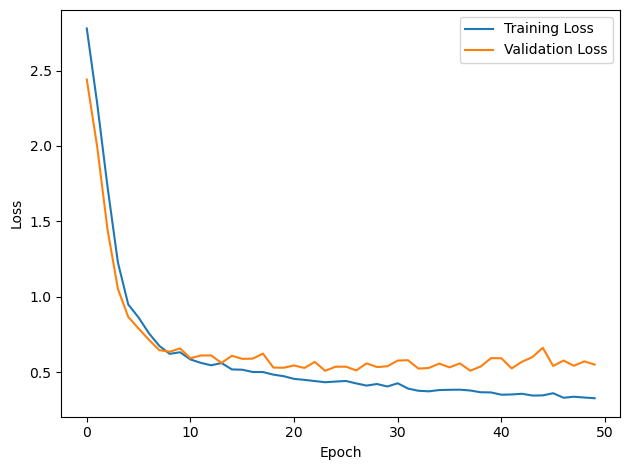

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 87.0%
TRAIN absolute error: 4.5 deg


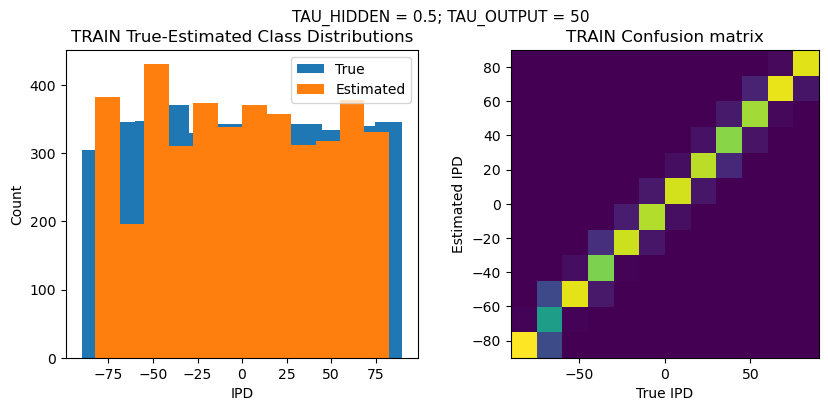


TEST classifier accuracy: 76.4%
TEST absolute error: 5.2 deg


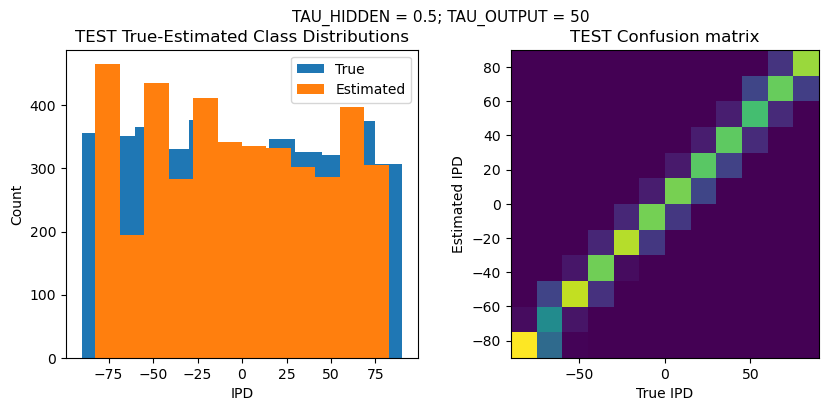

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 13/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 1 ms, TAU_OUTPUT = 5 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

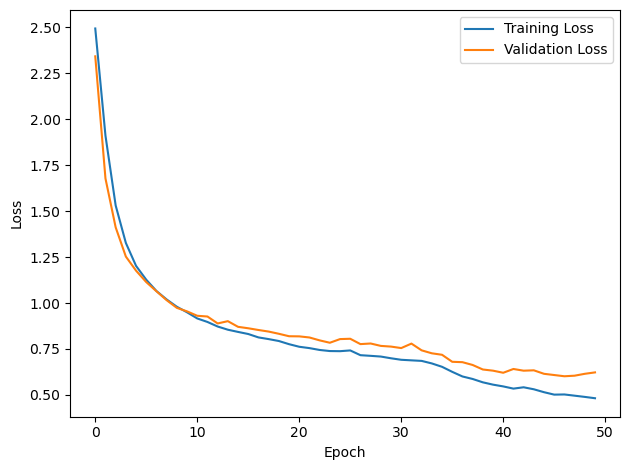

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 80.9%
TRAIN absolute error: 4.9 deg


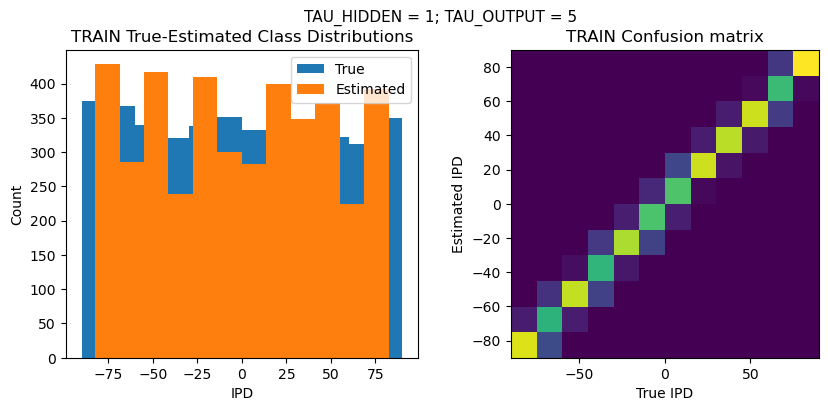


TEST classifier accuracy: 73.1%
TEST absolute error: 5.5 deg


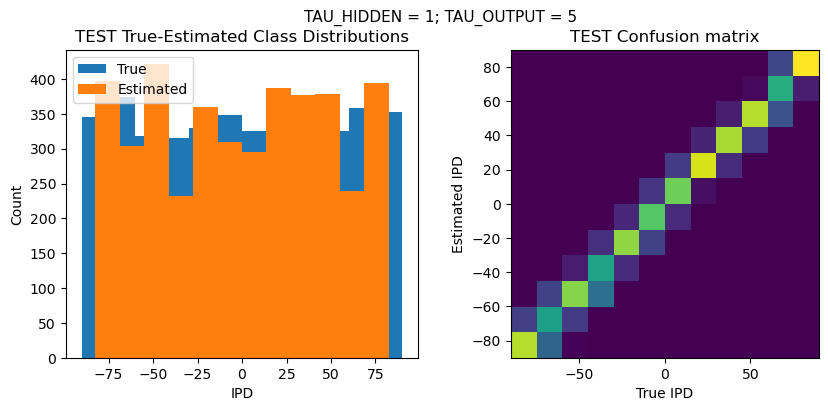

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 14/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 1 ms, TAU_OUTPUT = 10 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

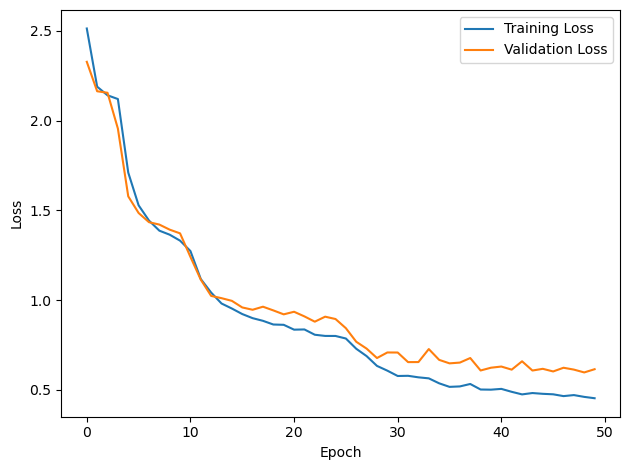

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 83.7%
TRAIN absolute error: 4.7 deg


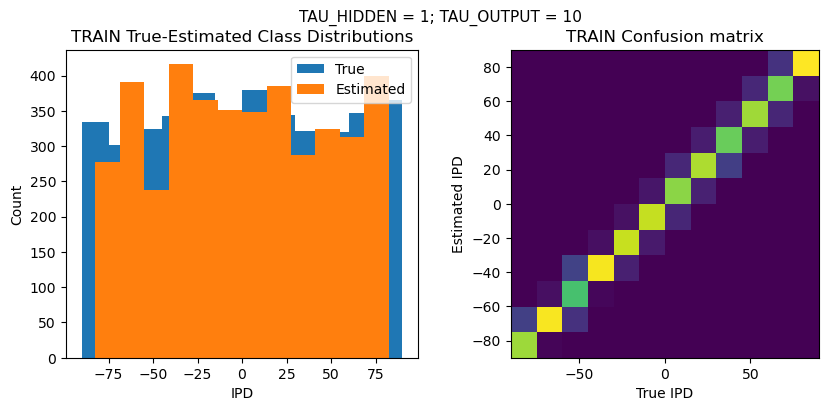


TEST classifier accuracy: 73.2%
TEST absolute error: 5.5 deg


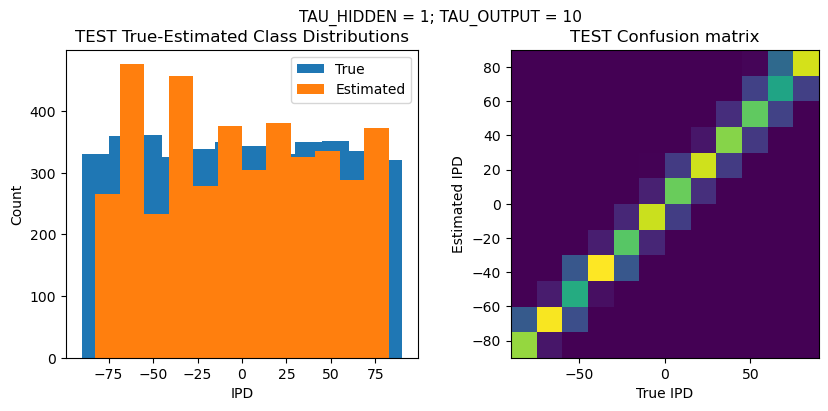

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 15/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 1 ms, TAU_OUTPUT = 20 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

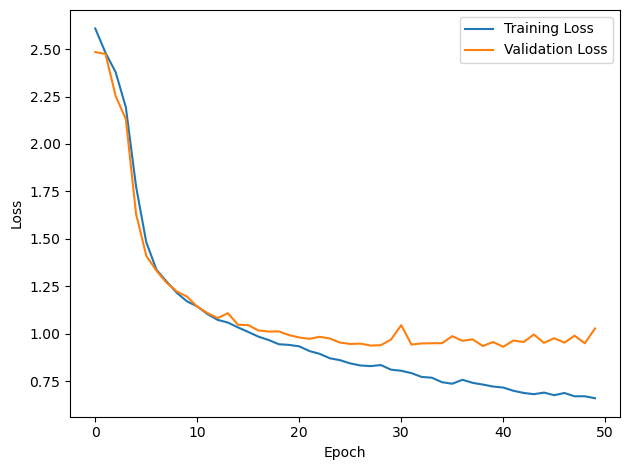

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 69.3%
TRAIN absolute error: 6.6 deg


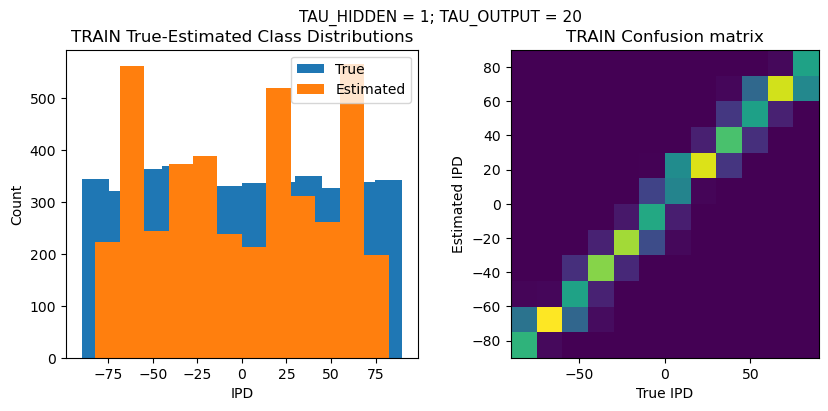


TEST classifier accuracy: 54.3%
TEST absolute error: 8.1 deg


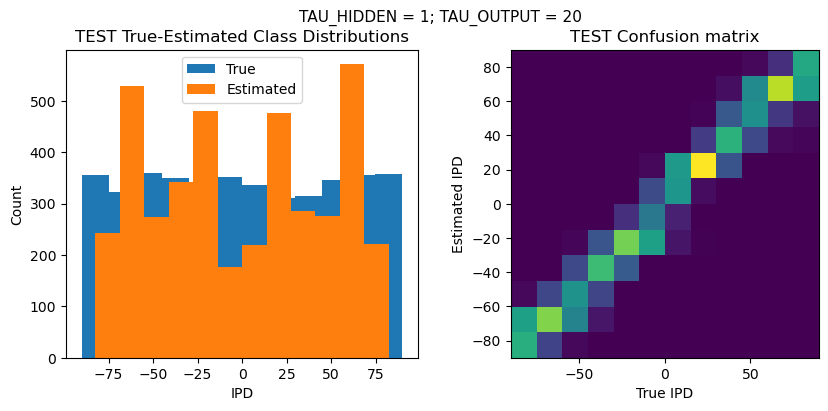

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 16/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 1 ms, TAU_OUTPUT = 30 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

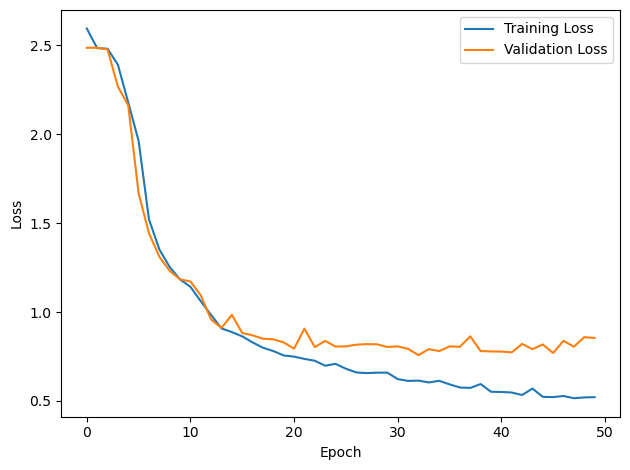

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 75.0%
TRAIN absolute error: 6.0 deg


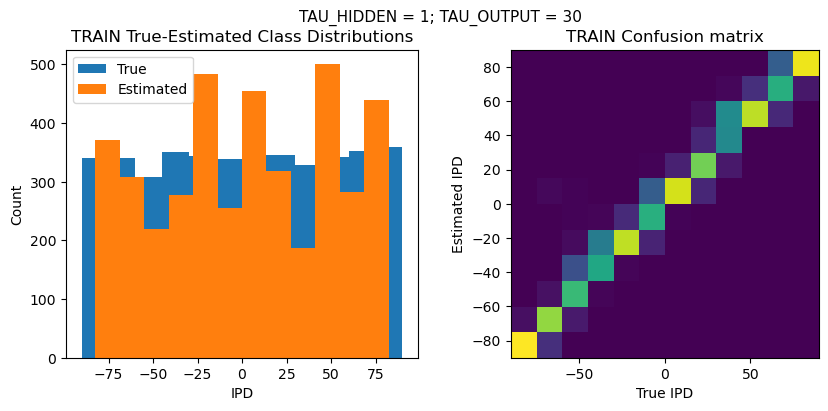


TEST classifier accuracy: 63.4%
TEST absolute error: 7.2 deg


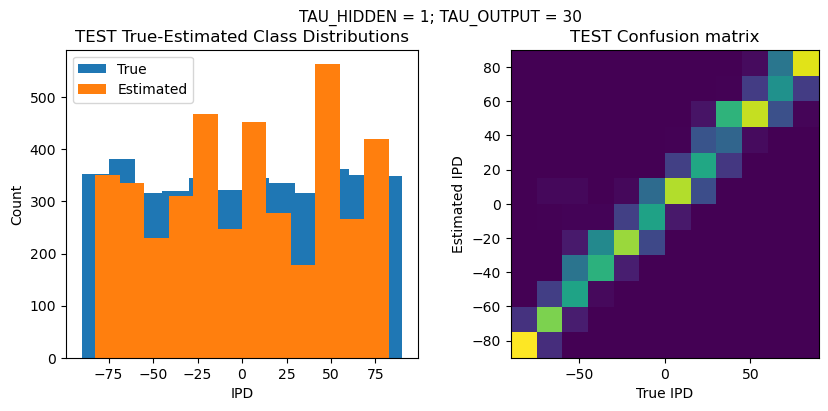

Time taken for this configuration: 51.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 17/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 1 ms, TAU_OUTPUT = 40 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

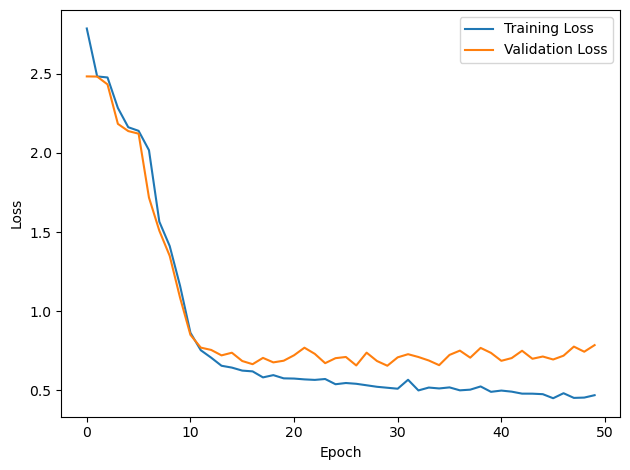

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 79.6%
TRAIN absolute error: 5.2 deg


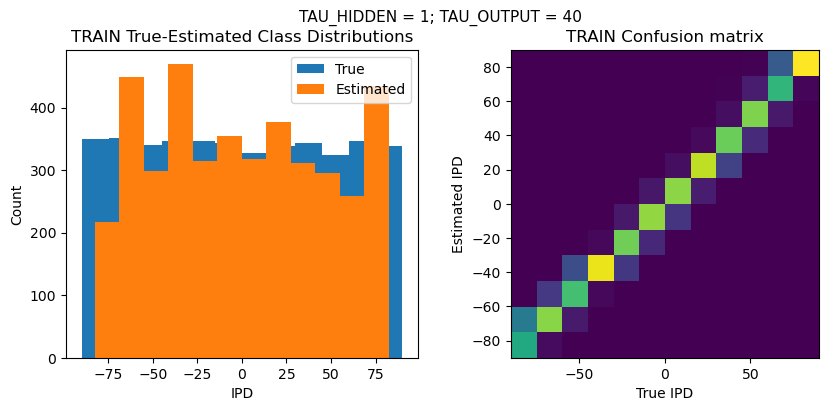


TEST classifier accuracy: 68.7%
TEST absolute error: 6.1 deg


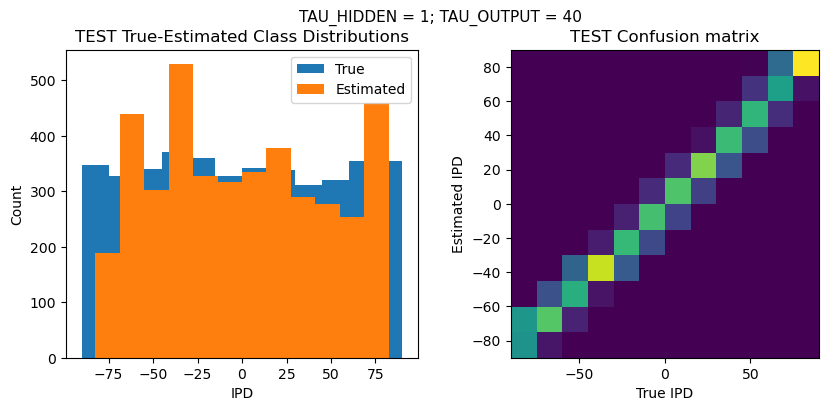

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 18/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 1 ms, TAU_OUTPUT = 50 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

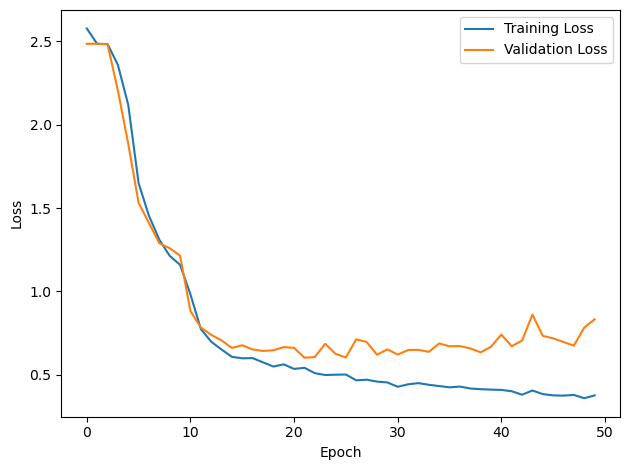

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 85.0%
TRAIN absolute error: 4.7 deg


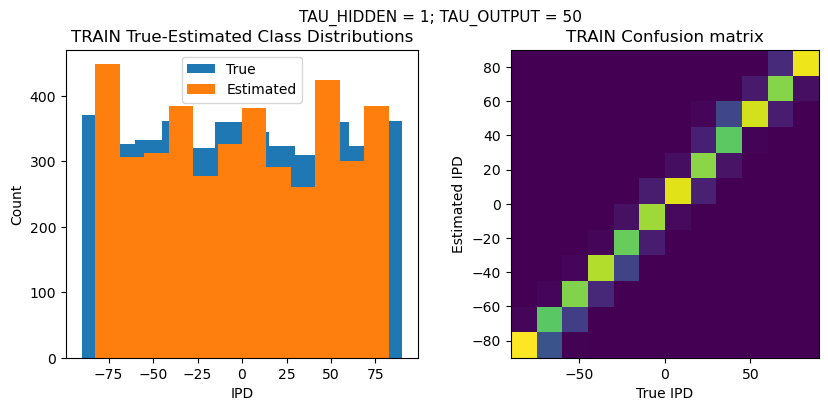


TEST classifier accuracy: 69.7%
TEST absolute error: 5.9 deg


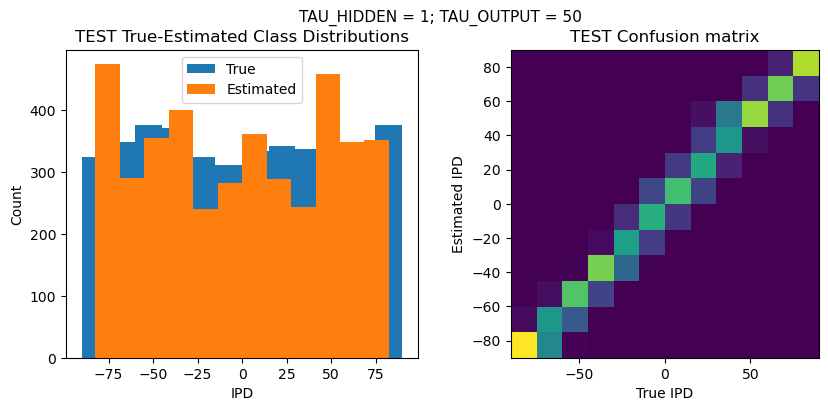

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 19/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 2 ms, TAU_OUTPUT = 5 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

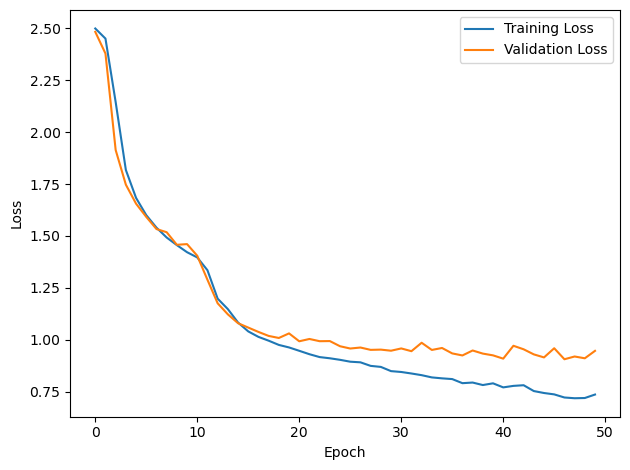

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 66.4%
TRAIN absolute error: 6.8 deg


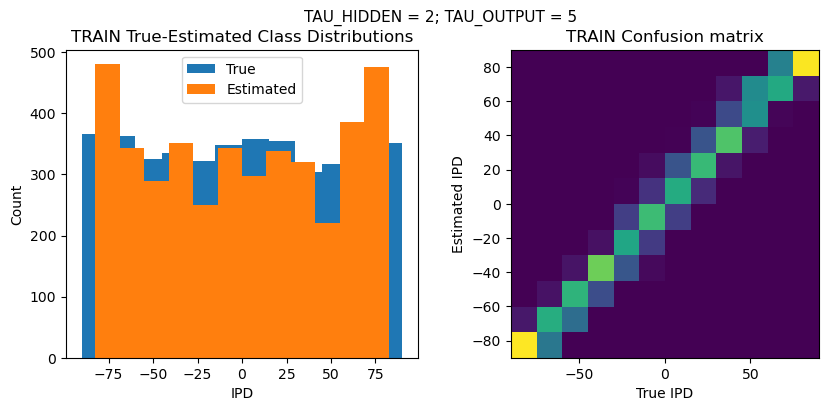


TEST classifier accuracy: 55.2%
TEST absolute error: 8.3 deg


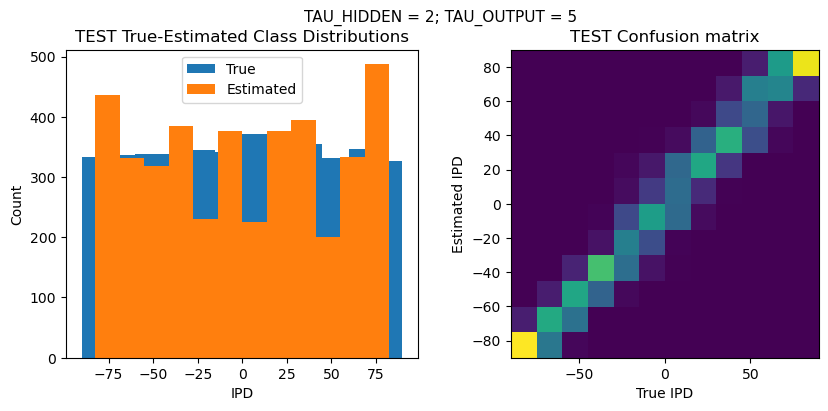

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 20/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 2 ms, TAU_OUTPUT = 10 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

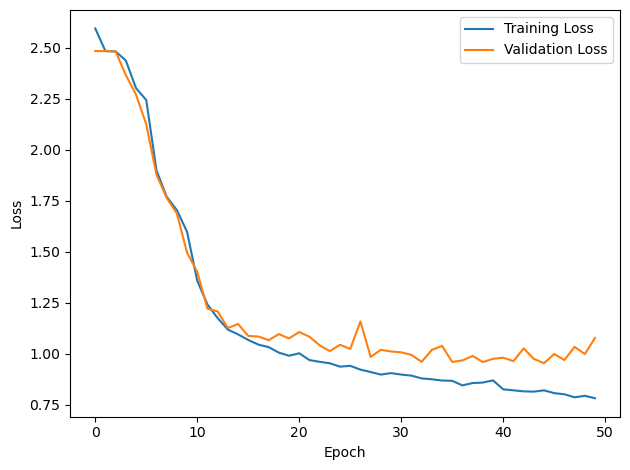

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 66.4%
TRAIN absolute error: 7.0 deg


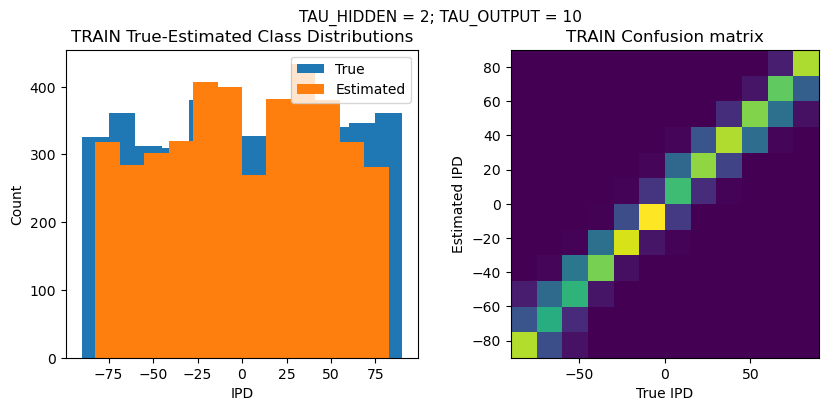


TEST classifier accuracy: 56.3%
TEST absolute error: 8.1 deg


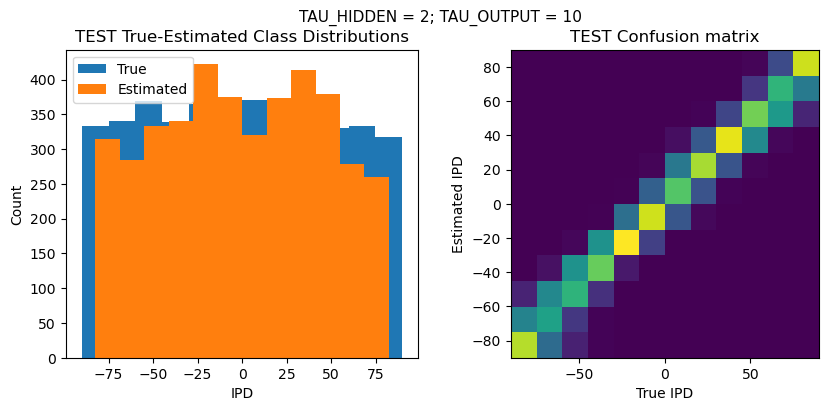

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 21/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 2 ms, TAU_OUTPUT = 20 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

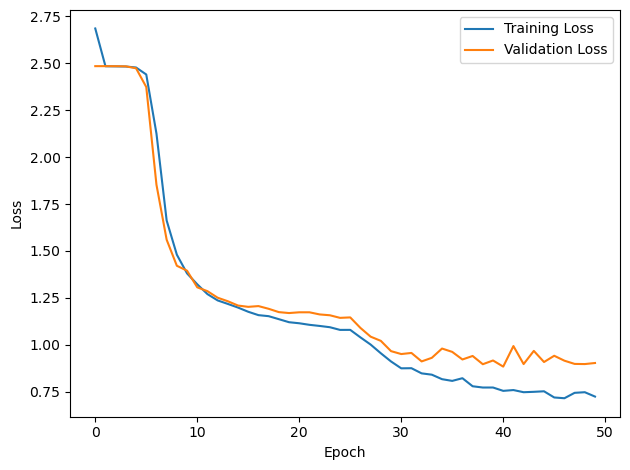

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 69.0%
TRAIN absolute error: 6.3 deg


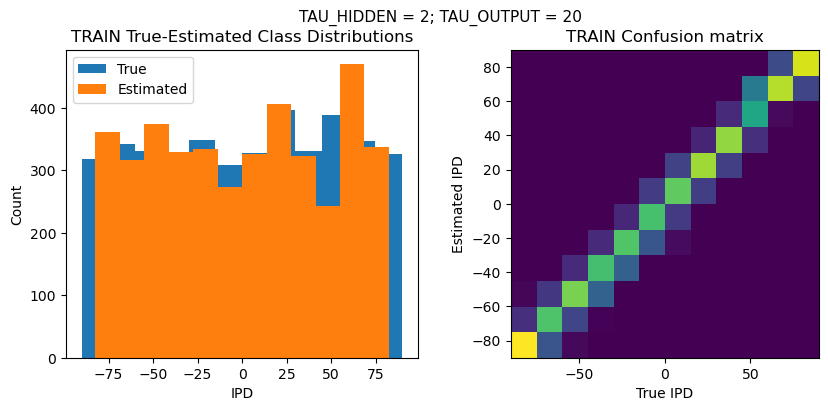


TEST classifier accuracy: 59.0%
TEST absolute error: 7.5 deg


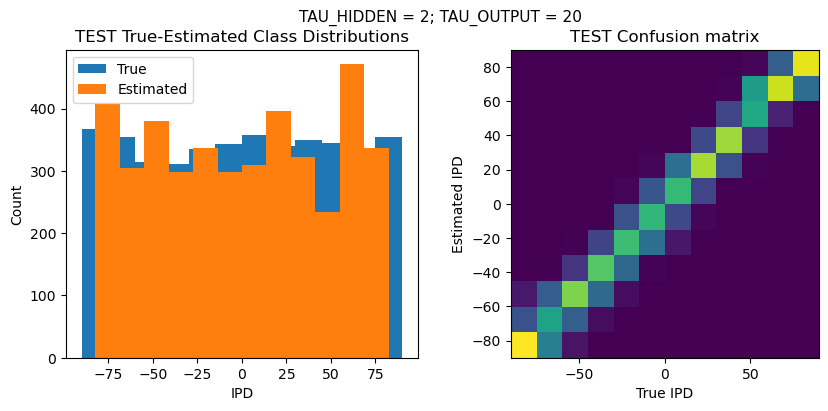

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 22/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 2 ms, TAU_OUTPUT = 30 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

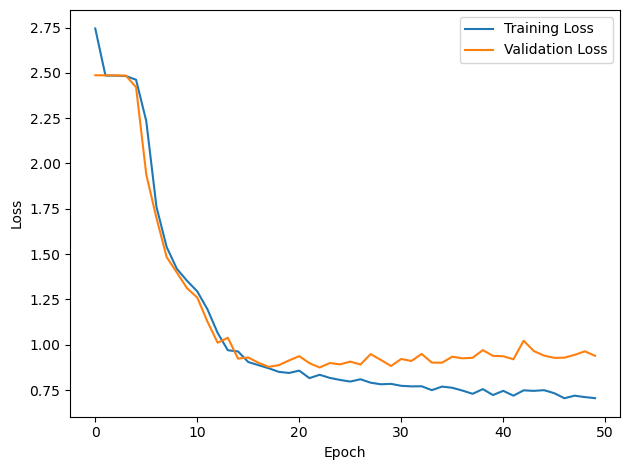

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 69.4%
TRAIN absolute error: 6.5 deg


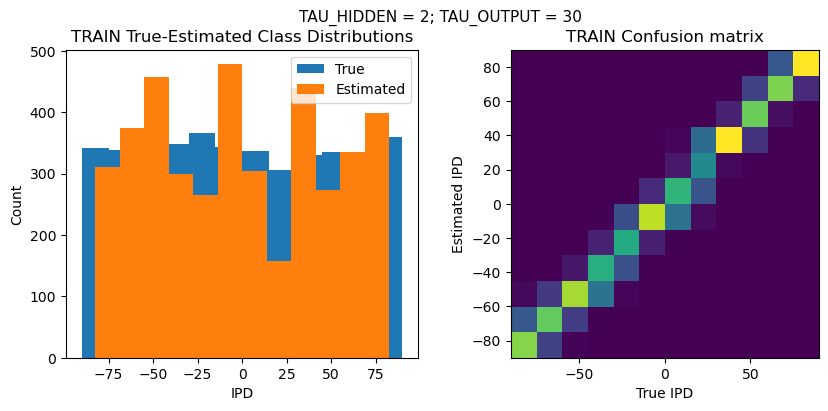


TEST classifier accuracy: 57.6%
TEST absolute error: 7.9 deg


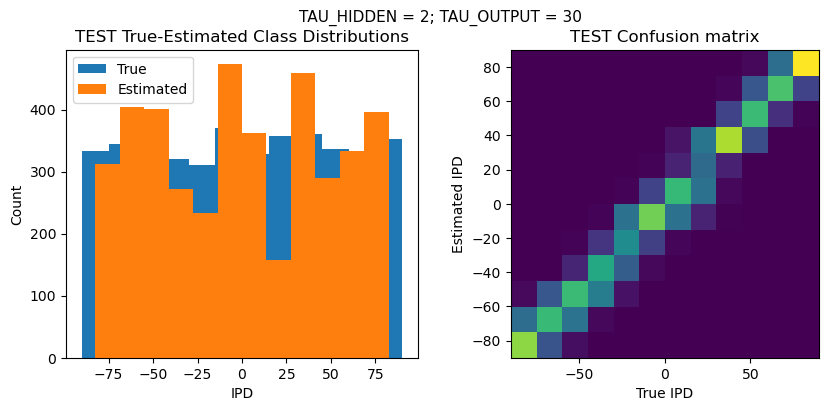

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 23/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 2 ms, TAU_OUTPUT = 40 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

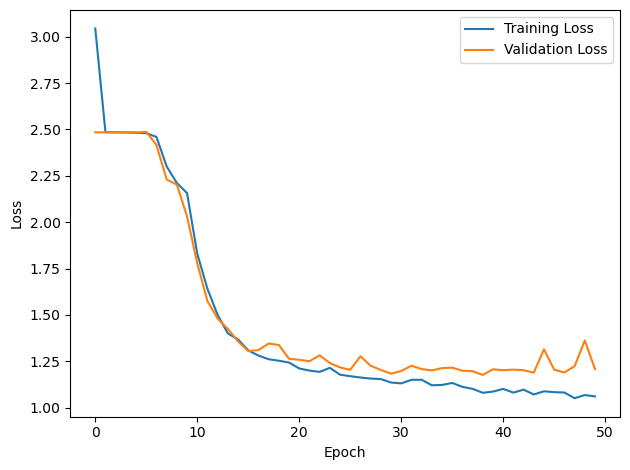

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 55.2%
TRAIN absolute error: 9.0 deg


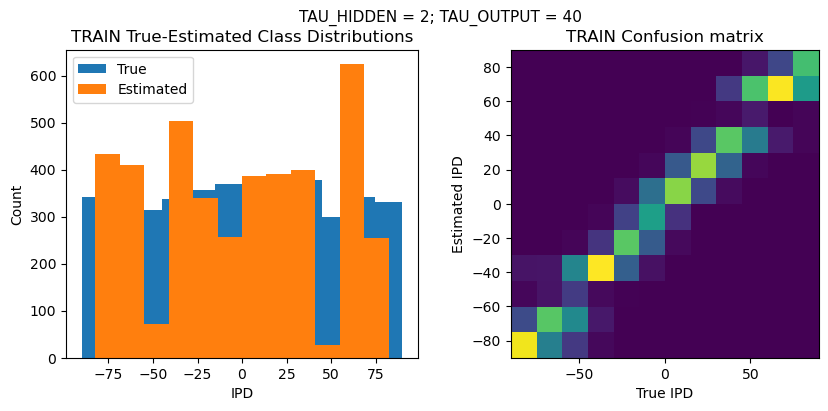


TEST classifier accuracy: 45.7%
TEST absolute error: 10.2 deg


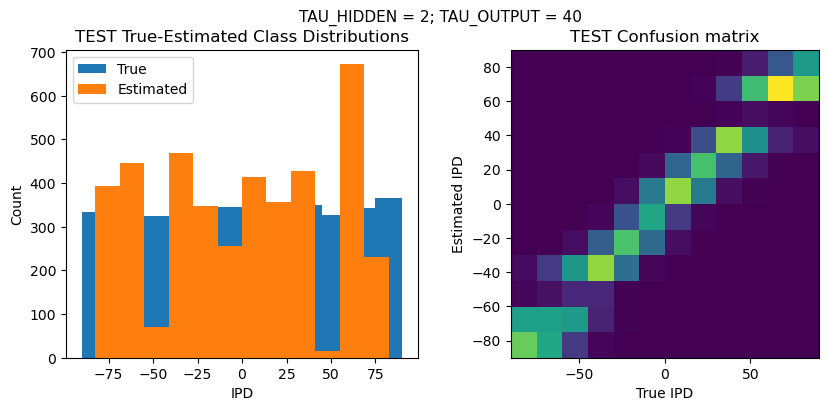

Time taken for this configuration: 50.0 min
------------------------------------------------------------------------------------------------------------------
 
>>> Training No. 24/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 2 ms, TAU_OUTPUT = 50 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
tau_hidden_list = [0.2, 0.5, 1, 2]
tau_output_list = [5, 10, 20, 30, 40, 50]
#lr_list = [0.01, 0.001]

training_count_total = len(tau_hidden_list) * len(tau_output_list)

overall_start_time = time.time()

training_count = 1
for tau_hidden in tau_hidden_list:
    for tau_output in tau_output_list:
        #for LR in lr_list:
            
        # Print configuration
        print('>>> Training No. {}/{}'.format(training_count, training_count_total))
        print(' ')
        print('CONFIGURATION:')
        config_str = f"DT = {DT*1e+3} ms, DURATION = {DURATION*1e+3} ms, STIMULUS_FREQUENCY = {STIMULUS_FREQUENCY} Hz, ENVELOPE_POWER = {ENVELOPE_POWER}, RATE_MAX = {RATE_MAX} Hz, NULL_PHASE_DELAYS = {NULL_PHASE_DELAYS}, LR = {LR}, N_EPOCHS = {N_EPOCHS}, EARLY_STOPPING_ENABLED = {EARLY_STOPPING_ENABLED}, BATCH_SIZE = {batch_size}, N_TRAINING_BATCHES = {n_training_batches}, N_TESTING_BATCHES = {n_testing_batches}, NUM_SAMPLES = {num_samples}, NUM_CLASSES = {NUM_CLASSES}, NUM_HIDDEN = {NUM_HIDDEN}, TAU_HIDDEN = {tau_hidden} ms, TAU_OUTPUT = {tau_output} ms, DALES_LAW = {DALES_LAW}, IE_RATIO (used if DALES_LAW) = {IE_RATIO}"
        print(' ')
        print(config_str)    
        print(' ')
            
        start_time = time.time()    
            
        # Generate the training data
        w1, w2, signs = init_weight_matrices(ie_ratio=IE_RATIO)
        ipds_training, spikes_training = random_ipd_input_signal(num_samples)
        ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)

        # Train network
        w1_trained, w2_trained, signs = train(w1, w2, signs, ipds_training, spikes_training, ipds_validation, spikes_validation, tau_hidden=tau_hidden*MS, tau_output=tau_output*MS, lr=LR, n_epochs=N_EPOCHS)

        # Analyse
        print(' ')
        print('PERFORMANCE:')
        print(' ')
        print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
        run_func = lambda x: snn(x, w1_trained, w2_trained, signs, tau_hidden=tau_hidden*MS, tau_output=tau_output*MS)
        analyse_accuracy(ipds_training, spikes_training, run_func, 'TRAIN')

        ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
        analyse_accuracy(ipds_test, spikes_test, run_func, 'TEST')
        
        end_time = time.time()
        time_taken_minutes = (end_time - start_time) / 60
        print('Time taken for this configuration: {} min'.format(round(time_taken_minutes, 0)))
        print('------------------------------------------------------------------------------------------------------------------')
        print(' ')
            
        training_count += 1

overall_end_time = time.time()
overall_time_taken_minutes = (overall_end_time - overall_start_time) / 60
overall_time_taken_hours = overall_time_taken_minutes / 60
print('LOOP IS DONE - {} configurations tested in {} minutes'.format(training_count_total, round(overall_time_taken_hours, 0)))


## 

>>> Training No. 24/24
 
CONFIGURATION:
 
DT = 0.1 ms, DURATION = 100.0 ms, STIMULUS_FREQUENCY = 250 Hz, ENVELOPE_POWER = 2, RATE_MAX = 600 Hz, NULL_PHASE_DELAYS = False, LR = 0.01, N_EPOCHS = 50, EARLY_STOPPING_ENABLED = True, BATCH_SIZE = 64, N_TRAINING_BATCHES = 64, N_TESTING_BATCHES = 64, NUM_SAMPLES = 4096, NUM_CLASSES = 12, NUM_HIDDEN = 5, TAU_HIDDEN = 2 ms, TAU_OUTPUT = 50 ms, DALES_LAW = False, IE_RATIO (used if DALES_LAW) = 0.5
 
 
TRAINING PROGRESS: 


  0%|          | 0/50 [00:00<?, ?it/s]

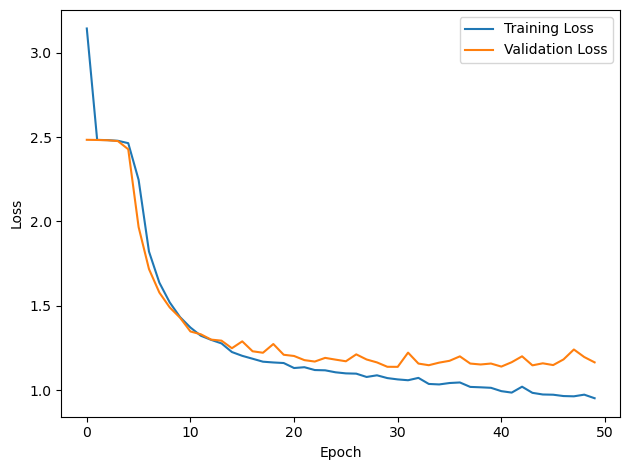

 
PERFORMANCE:
 
Chance accuracy level: 8.3%

TRAIN classifier accuracy: 60.2%
TRAIN absolute error: 8.3 deg


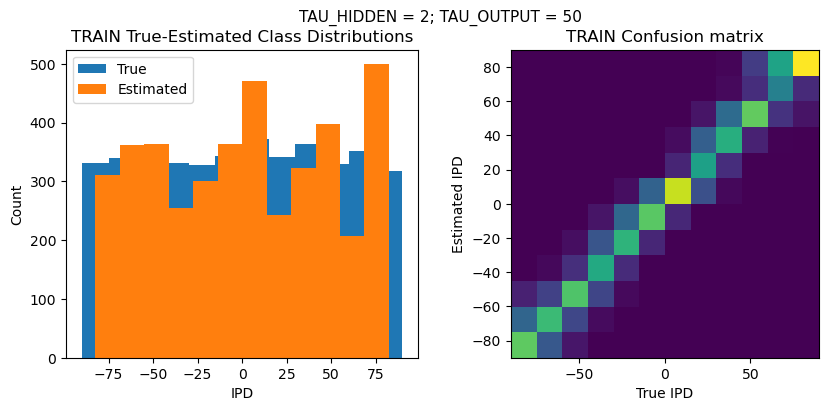


TEST classifier accuracy: 43.8%
TEST absolute error: 10.8 deg


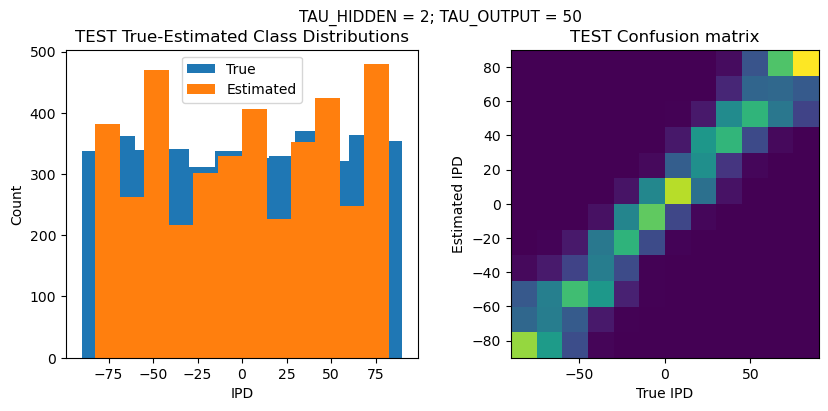

Time taken for this configuration: 41.0 min
------------------------------------------------------------------------------------------------------------------
 


In [11]:
# training for tau_hidden = 2 and tau_output = 50 as the program stopped running at that point above
tau_hidden = 2
tau_output = 50

training_count = 24
training_count_total = 24
# Print configuration
print('>>> Training No. {}/{}'.format(training_count, training_count_total))
print(' ')
print('CONFIGURATION:')
config_str = f"DT = {DT*1e+3} ms, DURATION = {DURATION*1e+3} ms, STIMULUS_FREQUENCY = {STIMULUS_FREQUENCY} Hz, ENVELOPE_POWER = {ENVELOPE_POWER}, RATE_MAX = {RATE_MAX} Hz, NULL_PHASE_DELAYS = {NULL_PHASE_DELAYS}, LR = {LR}, N_EPOCHS = {N_EPOCHS}, EARLY_STOPPING_ENABLED = {EARLY_STOPPING_ENABLED}, BATCH_SIZE = {batch_size}, N_TRAINING_BATCHES = {n_training_batches}, N_TESTING_BATCHES = {n_testing_batches}, NUM_SAMPLES = {num_samples}, NUM_CLASSES = {NUM_CLASSES}, NUM_HIDDEN = {NUM_HIDDEN}, TAU_HIDDEN = {tau_hidden} ms, TAU_OUTPUT = {tau_output} ms, DALES_LAW = {DALES_LAW}, IE_RATIO (used if DALES_LAW) = {IE_RATIO}"
print(' ')
print(config_str)    
print(' ')
    
start_time = time.time()    
    
# Generate the training data
w1, w2, signs = init_weight_matrices(ie_ratio=IE_RATIO)
ipds_training, spikes_training = random_ipd_input_signal(num_samples)
ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)

# Train network
w1_trained, w2_trained, signs = train(w1, w2, signs, ipds_training, spikes_training, ipds_validation, spikes_validation, tau_hidden=tau_hidden*MS, tau_output=tau_output*MS, lr=LR, n_epochs=N_EPOCHS)

# Analyse
print(' ')
print('PERFORMANCE:')
print(' ')
print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
run_func = lambda x: snn(x, w1_trained, w2_trained, signs, tau_hidden=tau_hidden*MS, tau_output=tau_output*MS)
analyse_accuracy(ipds_training, spikes_training, run_func, 'TRAIN')

ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse_accuracy(ipds_test, spikes_test, run_func, 'TEST')

end_time = time.time()
time_taken_minutes = (end_time - start_time) / 60
print('Time taken for this configuration: {} min'.format(round(time_taken_minutes, 0)))
print('------------------------------------------------------------------------------------------------------------------')
print(' ')

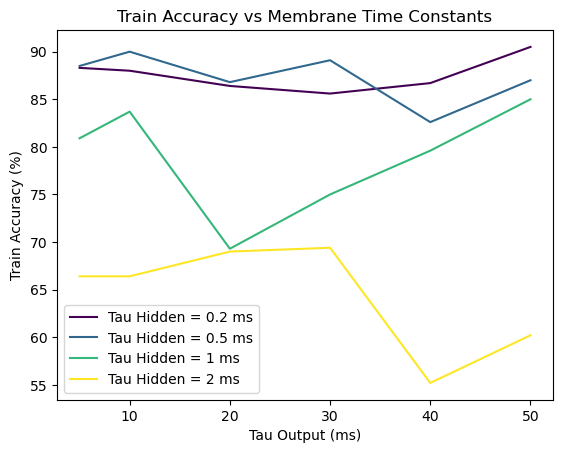

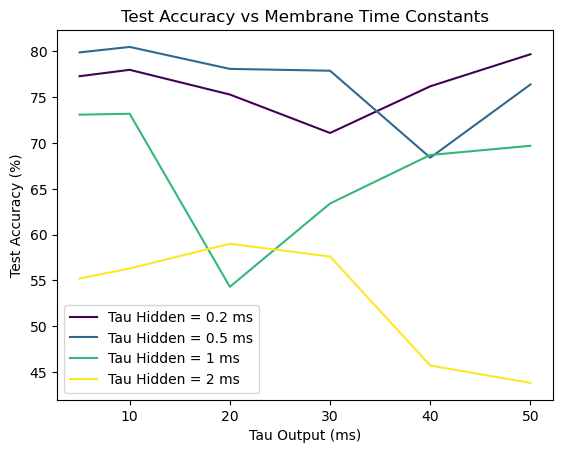

In [12]:
# Plot the training and test accuracies of the baseline SNN 
# for different values of the hidden and output membrane time constants
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def plot_baselineSNN_accuracy(accuracies, tau_hidden, tau_output, label):

    # Create a color map based on tau_output values
    cmap = get_cmap('viridis')  # You can choose any colormap you like

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Iterate over tau_hidden values and plot a line for each with the corresponding color
    for i, tau_hidden_value in enumerate(tau_hidden):
        color = cmap(i / (len(tau_hidden) - 1))  # Get color from the colormap
        ax.plot(tau_output, accuracies[i], label=f'Tau Hidden = {tau_hidden_value} ms', color=color)

    # Add labels, legend, and other plot details
    ax.set_xlabel('Tau Output (ms)')
    ax.set_ylabel(f'{label} Accuracy (%)')
    ax.legend()
    plt.title(f'{label} Accuracy vs Membrane Time Constants')

    # Show the plot
    plt.show()


# Membrane time constant values used for hidden and output neurons
tau_hidden = [0.2, 0.5, 1, 2]
tau_output = [5, 10, 20, 30, 40, 50]

# Baseline SNN accuracy for each tau_hidden-tau_output combination
# training performance
train_accuracy_data = np.array([
    [88.3, 88.0, 86.4, 85.6, 86.7, 90.5],  # accuracy for tau_hidden = 0.2
    [88.5, 90.0, 86.8, 89.1, 82.6, 87.0],  # accuracy for tau_hidden = 0.5
    [80.9, 83.7, 69.3, 75.0, 79.6, 85.0],  # accuracy for tau_hidden = 1
    [66.4, 66.4, 69.0, 69.4, 55.2, 60.2]   # accuracy for tau_hidden = 2
])
# test performance
test_accuracy_data = np.array([
    [77.3, 78.0, 75.3, 71.1, 76.2, 79.7],  # accuracy for tau_hidden = 0.2
    [79.9, 80.5, 78.1, 77.9, 68.4, 76.4],  # accuracy for tau_hidden = 0.5
    [73.1, 73.2, 54.3, 63.4, 68.7, 69.7],  # accuracy for tau_hidden = 1
    [55.2, 56.3, 59.0, 57.6, 45.7, 43.8]   # accuracy for tau_hidden = 2
])

# Plot the baseline SNN performance figures
plot_baselineSNN_accuracy(train_accuracy_data, tau_hidden, tau_output, label='Train')
plot_baselineSNN_accuracy(test_accuracy_data, tau_hidden, tau_output, label='Test')
